# Introduction

Hello people, welcome to this kernel. In this kernel I am going to classify tweets real or not real. Before starting, let's take a look at the content

# Notebook Content
1. Importing Libraries and The Data
1. Data Overview
1. Label Preprocessing
1. Cleaning Texts
1. Natural Language Processing
    * Tokenizing
    * Padding
    * Train Validation Split
1. Loading Trained GloVe Vectors
1. Modeling
    * Building GRU Model
    * Fitting GRU Model
    * Evaluating Validation Results
1. Submitting
1. Conclusion

# Importing Libraries And The Data

In this section I am going to import all the libraries that I will need and after that I will import the data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import nltk 
import re


from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense,CuDNNGRU,Embedding,GRU


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


* Now let's load the data.

In [2]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv') 
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Data Overview

In this section I am going to take a general look at the data, and I will determine which process will I do. Let's start.

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


* Keyword and location features seems useless, there must be too much missing values in them. But before deciding let's check the number of missing values.

In [5]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

* Although, keyword feature does not have too much missing keyword values, I won't use these features.

Now I will check random texts from the train set.

In [7]:
train_df.text[321]

'Armageddon https://t.co/uCSUDk3q1d'

* Clear and clear.

In [8]:
train_df.text[765]

"@iphooey @TIME Ironically Michele Bachmann brought this up in '11 w/Ron Paul &amp; everyone blew her off and called hoax. She was finally right"

# Label Preprocessing

In this section I am going to process our label. This section will be short, but I've still wanted to made this part as seperate.

In [9]:
# dropping unrelevant features
train_df.drop(["keyword","location"],axis=1,inplace=True)
test_df.drop(["keyword","location"],axis=1,inplace=True)

train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [11]:
x_train = train_df.text
y_train = train_df.target
x_test = test_df.text


In [12]:
y_train.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [13]:
y_train = pd.get_dummies(y_train)
y_train.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


* This part was finished.

# Cleaning Texts

In this section I am going to clean the text. I will use simple methods in order to clean the text. I will follow these steps:

1. Removing Links
1. Lowering 
1. Removing All The Things Except Characters

I am not sure these steps are most efficent way to clean text. But I will use it anyway.

In [14]:
clean_x_train = []
clean_x_test = []

# It means that remove everything except these chars.
pattern = "[^a-zA-Z0123456789]" 

for text in x_train:
    
    text = re.sub(r"http\S+", "", text)
    text = text.lower()
    text = re.sub(pattern," ",text)
    clean_x_train.append(text)    

for text in x_test:
    text = re.sub(r"http\S+", "", text)
    text = text.lower()
    text = re.sub(pattern," ",text)
    
    clean_x_test.append(text)

print(clean_x_train[:5])

    
    
    

['our deeds are the reason of this  earthquake may allah forgive us all', 'forest fire near la ronge sask  canada', 'all residents asked to  shelter in place  are being notified by officers  no other evacuation or shelter in place orders are expected', '13 000 people receive  wildfires evacuation orders in california ', 'just got sent this photo from ruby  alaska as smoke from  wildfires pours into a school ']


* I think our cleaned texts are ready, let's convert these cleaned texts list to np arrays.

In [15]:
x_train = np.array(clean_x_train) 
x_test = np.array(clean_x_test)
print(x_train.shape)
print(x_test.shape)

(7613,)
(3263,)


# Natural Language Processing

In this section I am going to prepare the texts in order to use in the deep learning. 

## Tokenizing

First, I am going to tokeinze all the texts. In order to do this I will use tensorflow's tokenizer.

In [16]:
tokenizer = Tokenizer(num_words=10000) 
total_texts = np.concatenate([x_train,x_test],axis=0)
tokenizer.fit_on_texts(total_texts)

list(tokenizer.word_index)[:20]

['the',
 'a',
 'to',
 'in',
 'of',
 'i',
 'and',
 's',
 'is',
 'you',
 'for',
 'on',
 'it',
 'my',
 'that',
 'with',
 'by',
 'at',
 't',
 'this']

* Now I am going to convert texts into tokens.

In [17]:
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train[321]

[582]

In [18]:
# checking random samples

x_train[875]

[2866, 6158, 216, 944, 344, 942, 396, 3371]

## Padding

Now, I am going to pad each sequences. In order to determine the number of each sequence, I will determine the sequence that have maximum length. This is the best approach.

In [19]:
total_len = [len(text) for text in total_texts]
print("The text that has maximum length has {} tokens.".format(max(total_len)))

The text that has maximum length has 157 tokens.


In [20]:
SEQUENCE_SIZE = 157
x_train_pad = pad_sequences(x_train,maxlen=157)
x_test_pad = pad_sequences(x_test,maxlen=157)

print(x_train_pad[321])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0 582]


## Train Validation Split

In this section I am gonna split train set into train and validation set. Maybe you don't know why we need to use validation sets, so I want to explain. In real-life problems. We use several models and in order to learn the success of model, we need to test the model. So we use validation set.  

In [21]:
x_train,x_val,Y_train,y_val = train_test_split(np.array(x_train_pad),np.array(y_train),test_size=0.15,random_state=1)

print("Shape of x_train is",x_train.shape)
print("Shape of x_val is",x_val.shape)
print("Shape of y_train is",Y_train.shape)
print("Shape of y_val is",y_val.shape)

Shape of x_train is (6471, 157)
Shape of x_val is (1142, 157)
Shape of y_train is (6471, 2)
Shape of y_val is (1142, 2)


# Loading Trained GloVe Vectors

You know, in order to classify texts, we need word vectors. Generally people use GloVe or word2vec. In this kernel I will use GloVe. We can train our word vectors but there are trained vectors, they have trained with bigger corpus so they are better. 

In this kernel I am going to use trained GloVe vectors from Stanford University, you can download them for their website, or just import it from the kaggle.

In [22]:
glove_vectors = {}
with open("../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt",encoding="UTF-8") as f:
    
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],dtype="float32")
        glove_vectors[word] = vectors

* We read our vectors but we can't use them in this moment, because there may be words that are in our words but non in trained words.
* In order to solve this problem, we will initialize random vectors.

In [23]:
NUM_TOKENIZER_WORDS = 10000
embedding_matrix = np.random.uniform(-1,1,(NUM_TOKENIZER_WORDS,100))
for word,i in tokenizer.word_index.items():
    if i<NUM_TOKENIZER_WORDS:
        embedding_vector = glove_vectors.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

1. First we initialize random vectors.
1. Then we started a for loop, this for loop return each word an its index from the tokenizer's word index.
1. If this word have a vector in glove_vectors, then we add glove vector to embedding matrix.
1. If there is no word, its value remains random.


# Modeling

In this section I am going to build,fit and evaluate a RNN model. In order to build a RNN model I will use Keras API. Let's start with building the model.

## Building GRU Model

You know, there are several types of RNNs, like SimpleRNN, LSTM. Generally people use LSTM (Long Short Term Memory) and GRU (Gated Recurrent Unit). In this kernel I am going to use GRU. Let's start.

In [24]:
state_size = 512

model = Sequential()

model.add(Embedding(input_dim=NUM_TOKENIZER_WORDS,
                    output_dim=100,
                    weights=[embedding_matrix],
                    trainable=True
                   ))

model.add(CuDNNGRU(state_size,return_sequences=True))

model.add(CuDNNGRU(state_size,return_sequences=False))

model.add(Dense(2,activation="sigmoid"))

model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

model.summary()
          

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
cu_dnngru (CuDNNGRU)         (None, None, 512)         943104    
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 512)               1575936   
_________________________________________________________________
dense (Dense)                (None, 2)                 1026      
Total params: 3,520,066
Trainable params: 3,520,066
Non-trainable params: 0
_________________________________________________________________


## Fitting The Model

In this section I am going to fit the model.

In [25]:
EPOCH_NUMBER = 4
history = model.fit(x_train,Y_train,epochs=EPOCH_NUMBER,validation_data=(x_val,y_val))

Epoch 1/4
203/203 [==============================] - 28s 139ms/step - loss: 0.4792 - accuracy: 0.7755 - val_loss: 0.4497 - val_accuracy: 0.7977
Epoch 2/4
203/203 [==============================] - 11s 53ms/step - loss: 0.3868 - accuracy: 0.8371 - val_loss: 0.4250 - val_accuracy: 0.8187
Epoch 3/4
203/203 [==============================] - 11s 54ms/step - loss: 0.3201 - accuracy: 0.8666 - val_loss: 0.4732 - val_accuracy: 0.8144
Epoch 4/4
203/203 [==============================] - 11s 53ms/step - loss: 0.2508 - accuracy: 0.9008 - val_loss: 0.5478 - val_accuracy: 0.8091


## Evaluating The Model
In this section I am going to evaluate the model. Let's start with the loss and accuracy chart.

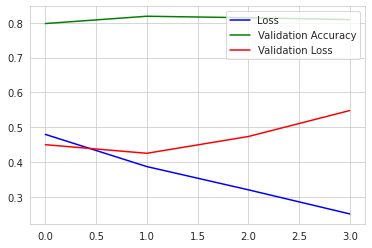

In [26]:
sns.set_style("whitegrid")
plt.plot(history.history["loss"],color="blue",label="Loss")
plt.plot(history.history["val_accuracy"],color="green",label="Validation Accuracy")
plt.plot(history.history["val_loss"],color="red",label="Validation Loss")
plt.legend(loc="upper right")
plt.show()

Now let's take a look at the confusion matrix of validation set.

In [27]:
model.evaluate(x_val,y_val)

36/36 [==============================] - 1s 16ms/step - loss: 0.5478 - accuracy: 0.8091


[0.5478349924087524, 0.8091068267822266]

In [28]:
y_pred = model.predict_classes(x_val)
print(y_pred[:10])

[1 0 0 0 0 0 0 0 1 0]


In [29]:
y_true = []
y_vallist = y_val.tolist()
for i in y_vallist:
    
    index = i.index(1)
    y_true.append(index)

print(y_true[:10])

[1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


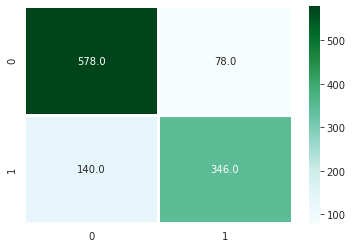

In [30]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_pred=y_pred,y_true=y_true)

sns.heatmap(matrix,annot=True,linewidths=2.0,cmap="BuGn",fmt=".1f")
plt.show()

# Submitting 

In this section I am going to predict x_test_pad and after that I will export the results as csv file.

In [31]:
sample = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [32]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3263 non-null   int64
 1   target  3263 non-null   int64
dtypes: int64(2)
memory usage: 51.1 KB


In [33]:
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [34]:
preds = model.predict_classes(x_test_pad)

In [35]:
preds[:10]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [36]:
sample["target"] = preds
sample.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [37]:
sample.to_csv('submission.csv')

# Conclusion

Thanks for your attention, if you have any question in your mind, please ask. I will definetely return to you. 

Have a great day!